# Design example of a concrete beam. Define geometry, loads, material, calculate, get results.

## Launch AxisVM

In [1]:
from axisvm.com.client import start_AxisVM

axisvm_application = start_AxisVM(visible=True, daemon=True, join=True)

In [2]:
import axisvm.com.tlb as axtlb

## Create a new model

In [3]:
axisvm_model_id = axisvm_application.Models.New()
axisvm_model = axisvm_application.Models.Item[axisvm_model_id]

## Create a material

In [4]:
axisvm_model.Settings.NationalDesignCode = axtlb.ndcEuroCode
concrete_material_id = axisvm_model.Materials.AddFromCatalog(axtlb.ndcEuroCode, "C16/20")
assert concrete_material_id > 0, f"Call to 'Materials.AddFromCatalog' failed with exit code {concrete_material_id}"

## Create a cross section

In [5]:
section_id = axisvm_model.CrossSections.AddRectangular(
    "section", 0.1, 0.15, axtlb.cspOther
)
assert section_id > 0, f"Call to 'CrossSections.AddRectangular' failed with exit code {section_id}"

## Create the geometry

Define the nodes


In [6]:
node_id_1 = axisvm_model.Nodes.AddWithDOF(0, 0, 0, axtlb.dofFrameXZ)
assert node_id_1 > 0, f"Call to 'Nodes.AddWithDOF' failed with exit code {node_id_1}"
node_id_2 = axisvm_model.Nodes.AddWithDOF(4, 0, 0, axtlb.dofFrameXZ)
assert node_id_2 > 0, f"Call to 'Nodes.AddWithDOF' failed with exit code {node_id_2}"

Define the line of the beam


In [7]:
line_id = axisvm_model.Lines.Add(node_id_1, node_id_2, axtlb.lgtStraightLine)[-1]
assert line_id > 0, f"Call to 'Lines.Add' failed with exit code {line_id}"

## Create the concrete member

In [8]:
member_id = axisvm_model.Members.Add([line_id])
assert member_id > 0, f"Call to 'Members.Add' failed with exit code {member_id}"

In [9]:
member = axisvm_model.Members.Item[member_id]

In [10]:
beam_id = member.DefineAsBeam(concrete_material_id, section_id, section_id)[-1]
assert beam_id > 0, f"Call to 'DefineAsBeam' failed with exit code {beam_id}"

## Define the supports

In [11]:
springleft = axtlb.RStiffnesses(x=1e12, y=1e12, z=1e12, xx=0, yy=0, zz=0)
springright = axtlb.RStiffnesses(x=1e12, y=1e12, z=1e12, xx=0, yy=0, zz=0)
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression,
)
RResistances = axtlb.RResistances(x=0, y=0, z=0, xx=0, yy=0, zz=0)
retval = axisvm_model.NodalSupports.AddNodalGlobal(
    springleft, RNonLinearity, RResistances, node_id_1
)[-1]
assert retval > 0, f"Call to 'NodalSupports.AddNodalGlobal' failed with exit code {retval}"
retval = axisvm_model.NodalSupports.AddNodalGlobal(
    springright, RNonLinearity, RResistances, node_id_2
)[-1]
assert retval > 0, f"Call to 'NodalSupports.AddNodalGlobal' failed with exit code {retval}"

## Define loads

### Permanent load group

In [12]:
group_id = axisvm_model.LoadGroups.Add(
    "Permanent", axtlb.lgtPermanent, True, axtlb.gctAdditive
)
assert group_id > 0, f"Call to 'LoadGroups.Add' failed with exit code {group_id}"

In [13]:
load_case_id = axisvm_model.LoadCases.AddWithGroup("G", axtlb.lctStandard, group_id)
assert load_case_id > 0, f"Call to 'LoadCases.AddWithGroup' failed with exit code {load_case_id}"

In [14]:
retval = axisvm_model.Loads.AddBeamSelfWeight(line_id, load_case_id)
assert retval > 0, f"Call to 'Loads.AddBeamSelfWeight' failed with exit code {retval}"

### Incidental load group 1

In [15]:
group_id = axisvm_model.LoadGroups.Add(
    "Incidental 1", axtlb.lgtIncidental, True, axtlb.gctExclusive
)
assert group_id > 0, f"Call to 'LoadGroups.Add' failed with exit code {group_id}"

In [16]:
load_case_id = axisvm_model.LoadCases.AddWithGroup("LC1", axtlb.lctStandard, group_id)

load = axtlb.RLoadBeamConcentrated(
    LoadCaseId=load_case_id,
    LineId=line_id,
    Fgz=-1.0,
    Position=-0.3,
    SystemGLR=axtlb.sysGlobal,
)

retval = axisvm_model.Loads.AddBeamConcentrated(load)[-1]
assert retval > 0, f"Call to 'Loads.AddBeamConcentrated' failed with exit code {retval}"

In [17]:
load_case_id = axisvm_model.LoadCases.AddWithGroup("LC2", axtlb.lctStandard, group_id)

load = axtlb.RLoadBeamConcentrated(
    LoadCaseId=load_case_id,
    LineId=line_id,
    Fgz=-10.0,
    Position=-0.6,
    SystemGLR=axtlb.sysGlobal,
)

retval = axisvm_model.Loads.AddBeamConcentrated(load)[-1]
assert retval > 0, f"Call to 'Loads.AddBeamDistributed' failed with exit code {retval}"

### Incidental load group 2

In [18]:
group_id = axisvm_model.LoadGroups.Add(
    "Incidental 2", axtlb.lgtIncidental, True, axtlb.gctExclusive
)
assert group_id > 0, f"Call to 'LoadGroups.Add' failed with exit code {group_id}"

In [19]:
load_case_id = axisvm_model.LoadCases.AddWithGroup("LC3", axtlb.lctStandard, group_id)

load = axtlb.RLoadBeamDistributed(
    LoadCaseId=load_case_id,
    LineId=line_id,
    qz1=-1.0,
    qz2=-1.0,
    Position1=0,
    Position2=-0.5,
    SystemGLR=axtlb.sysGlobal,
)

retval = axisvm_model.Loads.AddBeamDistributed(load)[-1]
assert retval > 0, f"Call to 'Loads.AddBeamDistributed' failed with exit code {retval}"

In [20]:
load_case_id = axisvm_model.LoadCases.AddWithGroup("LC4", axtlb.lctStandard, group_id)

load = axtlb.RLoadBeamDistributed(
    LoadCaseId=load_case_id,
    LineId=line_id,
    qz1=-1.0,
    qz2=-1.0,
    Position1=-0.5,
    Position2=-1.0,
    SystemGLR=axtlb.sysGlobal,
)
retval = axisvm_model.Loads.AddBeamDistributed(load)[-1]
assert retval > 0, f"Call to 'Loads.AddBeamDistributed' failed with exit code {retval}"

## Save the model

In [21]:
file_path = 'model.axs'
retval = axisvm_model.SaveToFile(file_path, False)
assert retval > 0, f"Call to 'AxisVMModel.SaveToFile' failed with exit code {retval}"

## Linear analysis

In [22]:
retval = axisvm_model.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)
assert retval > 0, f"Call to 'Calculation.LinearAnalysis' failed with exit code {retval}"

## Take a screenshot

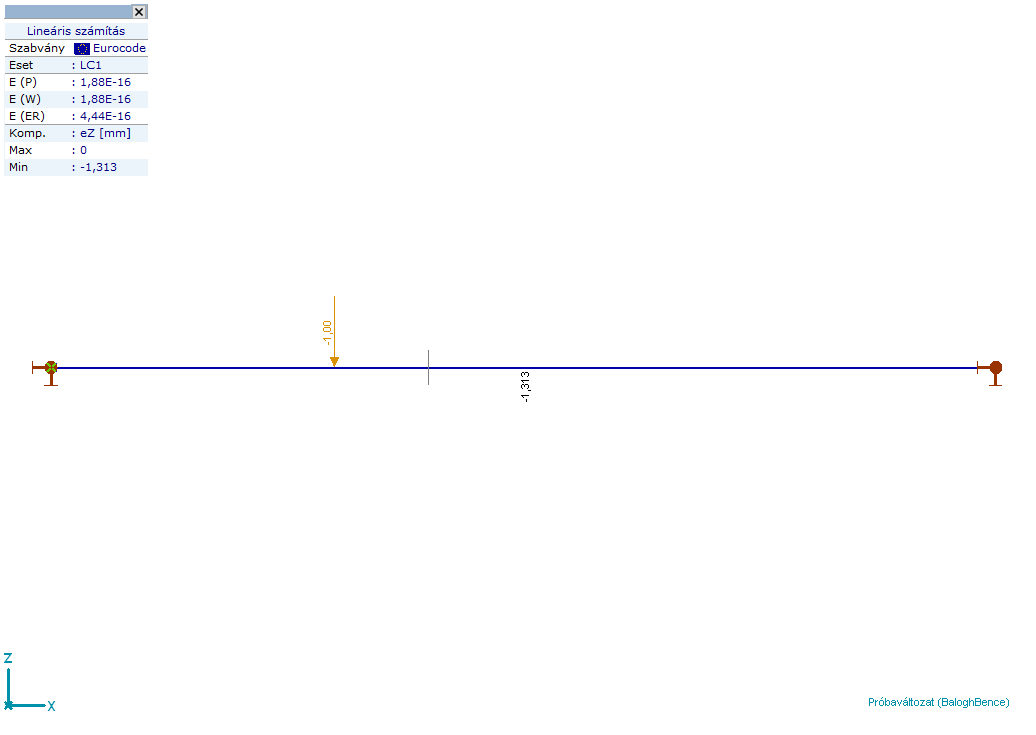

In [23]:
axisvm_model.View = axtlb.vFront
axisvm_model.FitInView()

# turn off the grid
GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axisvm_model.Settings.SetGridOptions(GridOptions)

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=True,
    Lines=True,
    MinMaxOnly=True
)

BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmDiagramFilled,
    DisplayShape=axtlb.dsUndeformed,
    WriteValuesTo=WriteValuesTo
)

ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCase
)

load_case_id = 3
axisvm_model.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, load_case_id, [])

axisvm_model.Windows.ReDraw()
axisvm_application.BringToFront()
axisvm_model.Windows[1].screenshot()

In [24]:
design_parameters = axtlb.RPartialRCBeamDesignParameters(
    RRCBeamCrossSections = axtlb.RRCBeamCrossSections(
        StartSection = axtlb.RRCBeamSection(
            bw = 0.2,
            h = 0.4,
            hf = 0.1,
            beff = 0.4
        ),
        EndSection = axtlb.RRCBeamSection(
            bw = 0.2,
            h = 0.4,
            hf = 0.1,
            beff = 0.4
        )
    ),
    RRCBeamSupports = axtlb.RRCBeamSupports(
        StartSupport = axtlb.RRCBeamSupport(
            OverWrite = False,
            ActualHalfWidth = 0.1,
            TheoreticalHalfWidth = 0.05,
            ShearReduction = False
        ),
        EndSupport = axtlb.RRCBeamSupport(
            OverWrite = False,
            ActualHalfWidth = 0.1,
            TheoreticalHalfWidth = 0.05,
            ShearReduction = False
        )
    )
)

retval = axisvm_model.RCBeamDesign.AddMembers([member_id], [design_parameters])
assert retval > 0, f"Call to 'RCBeamDesign.AddMembers' failed with exit code {retval}"

AssertionError: Call to 'RCBeamDesign.AddMembers' failed with exit code -100010

In [ ]:
"""(
    old_beam_design_parameters,  # an instance of RRCBeamDesignParameters
    old_design_code_parameters,  # an instance of RRCBeamDesignParameters_EC
) = axisvm_model.RCBeamDesign.GetDesignParameters(
    record_type=axtlb.RRCBeamDesignParameters_EC
)

old_beam_design_parameters.Dmax, old_design_code_parameters.TopSurface"""

'(\n    old_beam_design_parameters,  # an instance of RRCBeamDesignParameters\n    old_design_code_parameters,  # an instance of RRCBeamDesignParameters_EC\n) = axisvm_model.RCBeamDesign.GetDesignParameters(\n    record_type=axtlb.RRCBeamDesignParameters_EC\n)\n\nold_beam_design_parameters.Dmax, old_design_code_parameters.TopSurface'

In [ ]:
"""axisvm_model.RCBeamDesign.GetDesignParameters(
    record_type=axtlb.RRCBeamDesignParameters_EC
)[0].Dmax"""

'axisvm_model.RCBeamDesign.GetDesignParameters(\n    record_type=axtlb.RRCBeamDesignParameters_EC\n)[0].Dmax'

In [ ]:
rebar_steel_index = axisvm_model.RebarSteelGrades.AddFromCatalog(
    axtlb.ndcEuroCode, "B500A"
)

beam_design_parameters = axtlb.RRCBeamDesignParameters(
    ConcreteMaterial=concrete_material_id,
    Dmax=0.016,
    RebarMaterial=rebar_steel_index,
    StirrupMaterial=rebar_steel_index,
    StirrupDiameter=0.008,
    StirrupLegs=2,
    Shape=axtlb.rcbsRectangle,
    c_bottom=0.015,
    c_top=0.015,
    ds_bottom=0.0016,
    ds_top=0.016,
    TakeConcTensileStrengthNL=False,
    UsefctmflNL=False,
    ShrinkageEpsNL=0.0,
)

design_code_parameters = axtlb.RRCBeamDesignParameters_EC(
    VariableAngleTrussMethod=True,
    Theta=22,
    fse=1.0,
    ApplyMinimumCover=False,
    CrackWidthCheck=False,
    MaxCrackWidth_Bottom=0.0003,  # in metres
    MaxCrackWidth_Top=0.0003,  # in metres
    TakeConcTensileStrength=False,
    ShortTerm=False,
    Deflection_Beam_L_div=300.0,
    Deflection_Cantilever_L_div=400.0,
    TopSurface=axtlb.ecClassX0,
    BottomSurface=axtlb.ecClassX0,
    StructClass=axtlb.scS1,
    SeismicZone=axtlb.rcbsecSeismicH,
    PlasticHinges=axtlb.RRCBeamPlasticHinges(
        EnablePlasticHinges=False,
    ),
)

axisvm_model.RCBeamDesign.SetDesignParameters(
    beam_design_parameters, design_code_parameters
)

1

In [ ]:
axisvm_model.RCBeamDesign.GetDesignParameters(
    record_type=axtlb.RRCBeamDesignParameters_EC
)[0].Dmax

0.0

**The parameter 'Creep' is missing from the documentation.**

In [ ]:
axisvm_model.RCBeamDesign.Calculate(
    axtlb.rtLoadCombination,
    1,
    1,
    axtlb.atLinearStatic,
    False
)

(0, (), (), (), (), (), (), (), (), (), (), (), (), (), -100006)

In [ ]:
#axisvm_application.Quit()